# Problem 1: 10 Classifiers with logistic regression and MSE

## Import image data

In [1]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

(train_images_original, train_labels_original), (test_images_original, test_labels_original) = mnist.load_data()

Using TensorFlow backend.


## Preparing image data and hyperparameters

Problem 1 has been giving me trouble, not in its difficulty, but in tuning the hyperparameters.  The batch size I have attempted to keep at 128 per the example we have studied in class, but the learning rate seems to need to go to relatively huge levels to get any decent accuracy.  I have narrowed this issue down to the partial derivatives of the loss function, but as the math is absurdly simple, and I have verified that it is correct, I can only assume that this problem is due to the fact that creating 10 classifiers with mean squared error is bound to produce mediocre results.

In [0]:
train_images = train_images_original.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images_original.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

epochs = 10
batch_size = 128
lr = 0.9

## Function for converting labels to binary representation

This vectorized function takes each label in a list of labels, and, depending on the classifier being made, converts it to a binary label.  So if the classifier is for recognizing the number 2, then each label corresponding to 2 will be converted to 1 and all other labels are 0.

In [0]:
def convert_labels(old_label, new_label):
  return 1 if old_label == new_label else 0
convert_labels = np.vectorize(convert_labels)

## Logistic regression activation function

This function takes each element in a list of weighted inputs and passes it to the sigmoid.

In [0]:
def activation(z):
  return 1/(1 + np.exp(-z))

## Mean-squared-error loss function

This function takes the mean squared error between the activation result and the label.

In [0]:
def loss(a,y):
  return 0.5*(a-y)**2

## Classifier for each number

This classifier takes as input the number we will be training to classify.  It then converts all labels to binary representations for that number, and trains the network.  We do this for each number from 0 to 9. Each classifier returns the weights, bias, and list of loss values.

In [6]:
def classifier(num):
  # Convert labels to binary representation for number being trained.
  train_labels = convert_labels(train_labels_original, num)
  # Initialize random weights and bias.
  weights = np.random.randn(784)
  bias = np.random.randn()
  
  num_ims = len(train_images)
  
  # Average loss values across epochs
  loss_avgs = []
  
  for epoch in range(epochs):
    # Shuffle the training data on each epoch.
    shuffled_i = np.random.permutation(num_ims)
    X = train_images[shuffled_i]
    Y = train_labels[shuffled_i]
    
    # Calculate the average loss on each epoch.
    loss_epoch = 0.0
    for i in range(0, num_ims, batch_size):
        x = X[i:i+batch_size]
        y = Y[i:i+batch_size]
        
        # Take each training example in the batch and dot it with the
        # weights and then add the bias to get the weighted input.
        z = x.dot(weights) + bias
        # Pass the weighted input to the activation.
        a = activation(z)
        
        # Calculate the loss for this example and add it to loss for the epoch.
        loss_epoch += np.sum(loss(a, y))
        
        # Calculate the gradients with respect to the weights and bias
        # for each example.  
        gradient_b = (a - y) * a * (1.0 - a)
        
        # We need to reshape so that the vectorized operation for the gradient
        # is done correctly.
        gradient_b = np.reshape(gradient_b, (len(gradient_b),1))
        gradient_w = x * gradient_b
       
        # Average the gradients across the batch and use the resulting value in the updates.
        gradient_b = np.mean(gradient_b)
        gradient_w = np.mean(gradient_w,axis=0)
        
        weights = weights - lr * gradient_w
        bias = bias - lr * gradient_b
    
    # Record the progress of the current classifier.
    print("Classifier %d: Epoch %d/%d.\tLoss: %f" % (num, epoch+1, epochs, loss_epoch/num_ims))
    loss_avgs.append(loss_epoch/num_ims)
  print()
  
  return (weights, bias, loss_avgs)

# Train a list of classifiers, one for each digit.
classif_list = [classifier(i) for i in range(10)]

Classifier 0: Epoch 1/10.	Loss: 0.041435
Classifier 0: Epoch 2/10.	Loss: 0.015266
Classifier 0: Epoch 3/10.	Loss: 0.011954
Classifier 0: Epoch 4/10.	Loss: 0.010156
Classifier 0: Epoch 5/10.	Loss: 0.009037
Classifier 0: Epoch 6/10.	Loss: 0.008281
Classifier 0: Epoch 7/10.	Loss: 0.007703
Classifier 0: Epoch 8/10.	Loss: 0.007276
Classifier 0: Epoch 9/10.	Loss: 0.006934
Classifier 0: Epoch 10/10.	Loss: 0.006660

Classifier 1: Epoch 1/10.	Loss: 0.052234
Classifier 1: Epoch 2/10.	Loss: 0.024902
Classifier 1: Epoch 3/10.	Loss: 0.013181
Classifier 1: Epoch 4/10.	Loss: 0.009432
Classifier 1: Epoch 5/10.	Loss: 0.008093
Classifier 1: Epoch 6/10.	Loss: 0.007358
Classifier 1: Epoch 7/10.	Loss: 0.006861
Classifier 1: Epoch 8/10.	Loss: 0.006480
Classifier 1: Epoch 9/10.	Loss: 0.006175
Classifier 1: Epoch 10/10.	Loss: 0.005931

Classifier 2: Epoch 1/10.	Loss: 0.055408
Classifier 2: Epoch 2/10.	Loss: 0.048244
Classifier 2: Epoch 3/10.	Loss: 0.040038
Classifier 2: Epoch 4/10.	Loss: 0.027210
Classifier 2

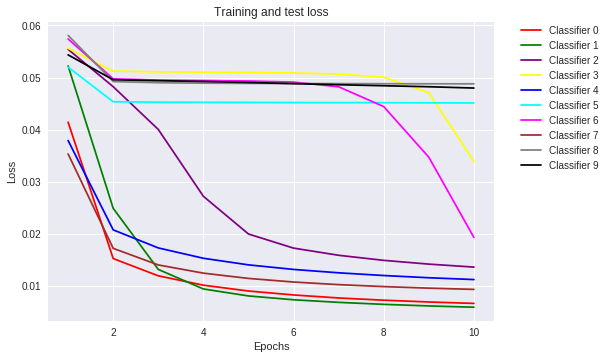

In [11]:
eps = range(1, epochs + 1)
colors = ['red', 'green', 'purple', 'yellow', 'blue', 'cyan', 'magenta', 'brown', 'gray', 'black']
for num in range(10):
  class_name = "Classifier %d" % num
  plt.plot(eps, classif_list[num][2], colors[num], label = class_name)
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Prediction function

This function takes a trained model for a classifier and a test example, and calculates the probability that the example is the number that the model is trained to recognize.

In [0]:
def predict(model, x):
  weights = model[0]
  bias = model[1]
  
  z = x.dot(weights) + bias
  return activation(z)

## Checking accuracy of each classifier

For each classifier, we pass it into a function that will determine how accurate the classifier is at recognizing its number by testing it on the entire test data set.

In [9]:
def single_classf_acc(num):
  num_true = 0
  
  # Convert all test labels to their binary form for the number
  # being recognized.
  test_labels = convert_labels(test_labels_original, num)
  
  for i in range(len(test_images)):
    xi = test_images[i]
    yi = test_labels[i]
    y_pred = predict(classif_list[num], xi)
    
    if y_pred>=0.5:
      y_pred = 1
    else:
      y_pred = 0

    if yi == y_pred:
      num_true+=1

  print("Classifier %d Accuracy: %f" % (num, num_true/len(test_images)))

print("Individual Accuracies of Classifiers:")
x = [single_classf_acc(i) for i in range(10)]

Individual Accuracies of Classifiers:
Classifier 0 Accuracy: 0.986500
Classifier 1 Accuracy: 0.988100
Classifier 2 Accuracy: 0.972900
Classifier 3 Accuracy: 0.940400
Classifier 4 Accuracy: 0.971200
Classifier 5 Accuracy: 0.910900
Classifier 6 Accuracy: 0.962200
Classifier 7 Accuracy: 0.979400
Classifier 8 Accuracy: 0.902600
Classifier 9 Accuracy: 0.900800


## Finding the accuracy of being able to recognize any number

Using the list of classifiers, pass the test data to them, and using argmax, determine which number each example is by choosing the classifier that "screams hardest".  Ouput how accurately the classifiers do this.

In [10]:
num_true = 0
for i in range(len(test_images)):
  xi = test_images[i]
  yi = test_labels_original[i]
  y_pred = np.argmax([predict(classif_list[i], xi) for i in range(10)])
  
  if yi == y_pred:
    num_true+=1
    
acc = num_true/len(test_images)
print("Overall Recognition Accuracy: %f" % acc)

Overall Recognition Accuracy: 0.665800
